# Classifier using LSTM layers

## 1. Importing Libraries

In [25]:
import torch

import pennylane as qml
import numpy as np
import pandas as pd

data_folder = '../data/quickdraw'

EPOCHS = 10
BATCH_SIZE = 40

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 2. Data Preprocessing

### 2.1. Loading the data

In [26]:
import os


def get_categories_from_data(folder, n=None):
    categories = []
    files = os.listdir(folder)

    for file in files:
        fname = file[16:-7]
        if len(fname) > 0:
            categories.append(fname)

    if n is None:
        return categories
    
    return categories[:n]

classes = get_categories_from_data(data_folder)
class_id = dict(zip(classes, range(len(classes))))


camera_data = np.load(f'../data/sketchrnn/sketchrnn_camera.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/sketchrnn/sketchrnn_cell_phone.npz', allow_pickle=True, encoding='latin1')

class_id

{'camera': 0, 'cell phone': 1}

In [27]:
def interpolate_strokes(strokes, target_length):
    """Interpolate a sequence of strokes to the target length."""
    current_length = len(strokes)
    if current_length == target_length:
        return strokes
    
    interpolated_strokes = np.zeros((target_length, 3), dtype=np.float32)
    interp_indices = np.floor(np.linspace(0, current_length-1, num=target_length)).astype(int)
    
    for i, idx in enumerate(interp_indices):
        interpolated_strokes[i] = strokes[idx]
    
    for i in range(target_length - 1):
        if interp_indices[i] != interp_indices[i + 1]:
            interpolated_strokes[i, 2] = strokes[interp_indices[i], 2]
        else:
            interpolated_strokes[i, 2] = 0
    
    # Ensure the last pen_state remains as the original last one
    interpolated_strokes[-1, 2] = strokes[-1, 2]
    
    return interpolated_strokes

def resize_and_normalize_drawings(data, size):
    """Resize and normalize drawing datasets."""
    resized_data = []
    for drawing in data['train']:
        resized_drawing = interpolate_strokes(drawing, size)
        resized_data.append(resized_drawing)
    return np.array(resized_data)

resized_camera_drawings = resize_and_normalize_drawings(camera_data, size=MAX_SEQ_LENGTH)
resized_cellphone_drawings = resize_and_normalize_drawings(cellphone_data, size=MAX_SEQ_LENGTH)


# TODO: Limitar dataset
resized_cellphone_drawings = resized_cellphone_drawings[:5000]
resized_camera_drawings = resized_camera_drawings[:5000]

resized_camera_drawings.shape, resized_cellphone_drawings.shape

((5000, 95, 3), (5000, 95, 3))

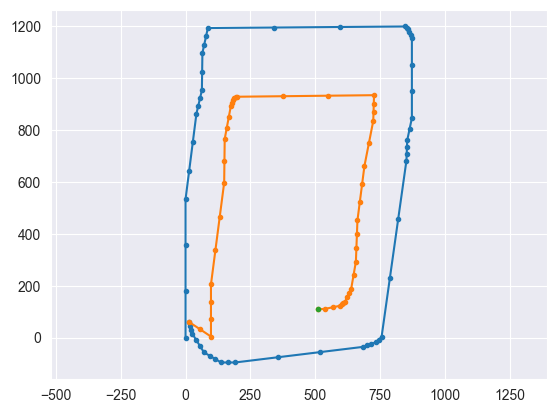

In [28]:
from matplotlib import pyplot as plt


def draw_strokes(data):
    """
    Draw stroke data from an array of (dx, dy, pen_state).

    Args:
    data (np.array): Stroke data array of shape (n, 3) where each row is (dx, dy, pen_state)
    """
    # Initialize a plot
    fig, ax = plt.subplots()
    
    # Starting point
    x, y = 0, 0
    points_x = [x]
    points_y = [y]

    # Iterate over the stroke data
    for dx, dy, pen_state in data:
        # Update position
        x += dx
        y += dy
        points_x.append(x)
        points_y.append(y)

        # If pen_state is 1, plot the current segment and start a new one
        if pen_state == 1:
            ax.plot(points_x, points_y, marker='.')
            points_x = [x]
            points_y = [y]

    # Plot the last segment
    ax.plot(points_x, points_y, marker='.')

    ax.axis('equal')
    plt.show()
    
draw_strokes(resized_cellphone_drawings[0])

In [29]:
from sklearn.model_selection import train_test_split

def prepare_train_test_datasets(camera_drawings, cellphone_drawings, test_size=0.2):
    """
    Prepare training and testing datasets from the resized drawing data of cameras and cellphones.
    
    Args:
    camera_drawings (np.array): Resized drawings of cameras.
    cellphone_drawings (np.array): Resized drawings of cellphones.
    test_size (float): The proportion of the dataset to include in the test split.
    
    Returns:
    tuple: Train and test datasets containing features and labels.
    """
    # Labels for the datasets
    camera_labels = np.zeros(camera_drawings.shape[0])
    cellphone_labels = np.ones(cellphone_drawings.shape[0])
    
    # Combine the drawings from both categories
    combined_drawings = np.concatenate([camera_drawings, cellphone_drawings], axis=0)
    combined_labels = np.concatenate([camera_labels, cellphone_labels], axis=0)
    
    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(
        combined_drawings, combined_labels, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_train_test_datasets(resized_camera_drawings, resized_cellphone_drawings, test_size=0.2)

In [30]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 95, 3), (8000,), (2000, 95, 3), (2000,))

In [31]:
from torch.utils.data import TensorDataset, DataLoader


def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.
    
    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    # Convert numpy arrays to TensorFlow tensors
    train_dataset = TensorDataset(torch.tensor(X_train).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device), torch.tensor(y_test, dtype=torch.long).to(device))
    
    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train, X_test, y_train, y_test)

# Setup DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
print(len(train_loader))
print(len(test_loader))

200
50


## 3. Model Building

### 3.1. Quantum Layer

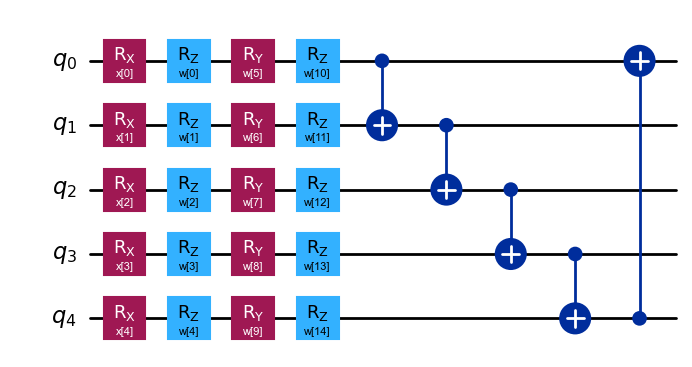

In [33]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)
    
    for i in range(n):
        circuit.rx(features[i], i)
    
    return circuit
    
def quantum_ansatz(n: int) -> QuantumCircuit:
    # Creamos un circuito cuántico con n qubits.
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)
    
    # Asumiendo que 'weights' es una lista de valores de peso,
    # y la longitud es suficiente para aplicar Rz a cada qubit.
    for i in range(n):
        circuit.rz(weights[i], i)
        
    # Aplicar más rotaciones, que en la imagen parecen ser Ry
    for i in range(n):
        circuit.ry(weights[n+i], i)
        
    for i in range(n):
        circuit.rz(weights[2*n+i], i)
        
    # Aplicar entrelazamiento con puertas CNOT
    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)
    
    return circuit

# Define and create QNN
def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)
    
    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN (
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.pool1 = nn.AvgPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.pool2 = nn.AvgPool1d(kernel_size=2)
        
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.pool3 = nn.AvgPool1d(kernel_size=2)
        
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(num_features=128)
        self.pool4 = nn.AvgPool1d(kernel_size=2)

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        
        self.pool5 = nn.AvgPool1d(kernel_size=2)
        
        # Dense layers
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)
        
        # Quantum layer
        self.fc3 = nn.Linear(64, n_qubits)
        self.qnn = TorchConnector(create_qnn(n_qubits)[0])
        
        # Dense layer for classification
        self.fc4 = nn.Linear(2**n_qubits, num_categories)
        
        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        x = x.permute(0, 2, 1)
        
        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        # Reshape for LSTM
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Pool layer
        x = self.pool5(x)
        
        # Flatten the output for dense layer
        x = torch.flatten(x, 1)
        
        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Quantum layer
        x = F.relu(self.fc3(x))
        x = self.qnn(x)
        
        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [35]:
checkpoint_filepath = 'models/2edition_quantum_lstm/best_model_weights.pth'

In [36]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            
            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(100):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

100%|██████████| 200/200 [07:32<00:00,  2.26s/it]


Epoch 1, Accuracy: 0.759625, Loss: 0.6490708702802658, Validation Accuracy: 0.831, Validation Loss: 0.6378693580627441


100%|██████████| 200/200 [07:27<00:00,  2.24s/it]


Epoch 2, Accuracy: 0.831375, Loss: 0.5826811653375625, Validation Accuracy: 0.955, Validation Loss: 0.5550097823143005


100%|██████████| 200/200 [07:25<00:00,  2.23s/it]


Epoch 3, Accuracy: 0.855, Loss: 0.5368579970300198, Validation Accuracy: 0.926, Validation Loss: 0.5325438976287842


100%|██████████| 200/200 [07:18<00:00,  2.19s/it]


Epoch 4, Accuracy: 0.874625, Loss: 0.5058306595683097, Validation Accuracy: 0.876, Validation Loss: 0.501969575881958


100%|██████████| 200/200 [07:07<00:00,  2.14s/it]


Epoch 5, Accuracy: 0.882125, Loss: 0.48539565488696096, Validation Accuracy: 0.904, Validation Loss: 0.5009397268295288


100%|██████████| 200/200 [07:00<00:00,  2.10s/it]


Epoch 6, Accuracy: 0.897, Loss: 0.4705350460112095, Validation Accuracy: 0.9475, Validation Loss: 0.46581578254699707


100%|██████████| 200/200 [07:02<00:00,  2.11s/it]


Epoch 7, Accuracy: 0.90575, Loss: 0.4508393079042435, Validation Accuracy: 0.9705, Validation Loss: 0.4396044611930847


100%|██████████| 200/200 [06:50<00:00,  2.05s/it]


Epoch 8, Accuracy: 0.923875, Loss: 0.4362569400668144, Validation Accuracy: 0.946, Validation Loss: 0.43309637904167175


100%|██████████| 200/200 [06:51<00:00,  2.06s/it]


Epoch 9, Accuracy: 0.929625, Loss: 0.42778494730591776, Validation Accuracy: 0.9385, Validation Loss: 0.4375241994857788


100%|██████████| 200/200 [06:59<00:00,  2.10s/it]


Epoch 10, Accuracy: 0.942875, Loss: 0.41786366313695905, Validation Accuracy: 0.9795, Validation Loss: 0.41376790404319763


100%|██████████| 200/200 [07:50<00:00,  2.35s/it]


Epoch 11, Accuracy: 0.942625, Loss: 0.4112245756387711, Validation Accuracy: 0.639, Validation Loss: 0.4034059941768646


100%|██████████| 200/200 [07:07<00:00,  2.14s/it]


Epoch 12, Accuracy: 0.940875, Loss: 0.40739042475819587, Validation Accuracy: 0.9735, Validation Loss: 0.40710094571113586


100%|██████████| 200/200 [07:19<00:00,  2.20s/it]


Epoch 13, Accuracy: 0.95625, Loss: 0.3994977295398712, Validation Accuracy: 0.8555, Validation Loss: 0.407858669757843


100%|██████████| 200/200 [07:13<00:00,  2.17s/it]


Epoch 14, Accuracy: 0.9625, Loss: 0.39578219547867777, Validation Accuracy: 0.9775, Validation Loss: 0.3993125259876251


100%|██████████| 200/200 [07:03<00:00,  2.12s/it]


Epoch 15, Accuracy: 0.955125, Loss: 0.39253208830952646, Validation Accuracy: 0.98, Validation Loss: 0.3925868570804596


100%|██████████| 200/200 [06:57<00:00,  2.09s/it]


Epoch 16, Accuracy: 0.958875, Loss: 0.38771184399724007, Validation Accuracy: 0.9735, Validation Loss: 0.39714837074279785


100%|██████████| 200/200 [07:13<00:00,  2.17s/it]


Epoch 17, Accuracy: 0.974, Loss: 0.38480728939175607, Validation Accuracy: 0.9825, Validation Loss: 0.38646262884140015


100%|██████████| 200/200 [07:16<00:00,  2.18s/it]


Epoch 18, Accuracy: 0.969875, Loss: 0.37955149114131925, Validation Accuracy: 0.984, Validation Loss: 0.3832789957523346


100%|██████████| 200/200 [07:10<00:00,  2.15s/it]


Epoch 19, Accuracy: 0.96, Loss: 0.3834020881354809, Validation Accuracy: 0.9775, Validation Loss: 0.38923150300979614


100%|██████████| 200/200 [07:17<00:00,  2.19s/it]


Epoch 20, Accuracy: 0.978125, Loss: 0.37934564739465715, Validation Accuracy: 0.981, Validation Loss: 0.38361790776252747


100%|██████████| 200/200 [07:12<00:00,  2.16s/it]


Epoch 21, Accuracy: 0.9775, Loss: 0.3758457265794277, Validation Accuracy: 0.984, Validation Loss: 0.3839958608150482


100%|██████████| 200/200 [07:08<00:00,  2.14s/it]


Epoch 22, Accuracy: 0.970375, Loss: 0.3754356721043587, Validation Accuracy: 0.9825, Validation Loss: 0.3827863037586212


100%|██████████| 200/200 [07:14<00:00,  2.17s/it]


Epoch 23, Accuracy: 0.97725, Loss: 0.3765769051015377, Validation Accuracy: 0.979, Validation Loss: 0.38442909717559814


100%|██████████| 200/200 [07:17<00:00,  2.19s/it]


Epoch 24, Accuracy: 0.965625, Loss: 0.3727046862244606, Validation Accuracy: 0.9805, Validation Loss: 0.38225966691970825


100%|██████████| 200/200 [07:08<00:00,  2.14s/it]


Epoch 25, Accuracy: 0.98675, Loss: 0.3662167662382126, Validation Accuracy: 0.984, Validation Loss: 0.38069331645965576


100%|██████████| 200/200 [07:10<00:00,  2.15s/it]


Epoch 26, Accuracy: 0.985375, Loss: 0.3669137775152922, Validation Accuracy: 0.983, Validation Loss: 0.379586786031723


100%|██████████| 200/200 [07:12<00:00,  2.16s/it]


Epoch 27, Accuracy: 0.972375, Loss: 0.3717459350824356, Validation Accuracy: 0.986, Validation Loss: 0.3776218295097351


100%|██████████| 200/200 [07:13<00:00,  2.17s/it]


Epoch 28, Accuracy: 0.983375, Loss: 0.367016663402319, Validation Accuracy: 0.9845, Validation Loss: 0.3773273527622223


100%|██████████| 200/200 [07:06<00:00,  2.13s/it]


Epoch 29, Accuracy: 0.978875, Loss: 0.36932356260716914, Validation Accuracy: 0.985, Validation Loss: 0.38427460193634033


100%|██████████| 200/200 [07:11<00:00,  2.16s/it]


Epoch 30, Accuracy: 0.984375, Loss: 0.36714209012687204, Validation Accuracy: 0.9805, Validation Loss: 0.3773318827152252


100%|██████████| 200/200 [07:13<00:00,  2.17s/it]


Epoch 31, Accuracy: 0.98775, Loss: 0.3630670250207186, Validation Accuracy: 0.9825, Validation Loss: 0.37538135051727295


100%|██████████| 200/200 [07:08<00:00,  2.14s/it]


Epoch 32, Accuracy: 0.9725, Loss: 0.36582823351025584, Validation Accuracy: 0.984, Validation Loss: 0.3812592625617981


100%|██████████| 200/200 [07:18<00:00,  2.19s/it]


Epoch 33, Accuracy: 0.97875, Loss: 0.36357831381261346, Validation Accuracy: 0.9855, Validation Loss: 0.37398868799209595


100%|██████████| 200/200 [07:27<00:00,  2.24s/it]


Epoch 34, Accuracy: 0.989125, Loss: 0.36119733907282353, Validation Accuracy: 0.981, Validation Loss: 0.37773510813713074


100%|██████████| 200/200 [07:24<00:00,  2.22s/it]


Epoch 35, Accuracy: 0.987125, Loss: 0.36216080173850057, Validation Accuracy: 0.978, Validation Loss: 0.3942742943763733


100%|██████████| 200/200 [07:08<00:00,  2.14s/it]


Epoch 36, Accuracy: 0.98075, Loss: 0.36032729744911196, Validation Accuracy: 0.9835, Validation Loss: 0.37912222743034363


100%|██████████| 200/200 [07:19<00:00,  2.20s/it]


Epoch 37, Accuracy: 0.990125, Loss: 0.3593886135518551, Validation Accuracy: 0.9825, Validation Loss: 0.38043105602264404


100%|██████████| 200/200 [07:23<00:00,  2.22s/it]


Epoch 38, Accuracy: 0.98975, Loss: 0.3580567090958357, Validation Accuracy: 0.9805, Validation Loss: 0.3781035244464874


100%|██████████| 200/200 [07:02<00:00,  2.11s/it]


Epoch 39, Accuracy: 0.990125, Loss: 0.35806791603565213, Validation Accuracy: 0.984, Validation Loss: 0.378797709941864


100%|██████████| 200/200 [06:47<00:00,  2.04s/it]


Epoch 40, Accuracy: 0.989, Loss: 0.35943928934633734, Validation Accuracy: 0.9725, Validation Loss: 0.40430065989494324


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 41, Accuracy: 0.981625, Loss: 0.36573021426796914, Validation Accuracy: 0.986, Validation Loss: 0.371805876493454


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 42, Accuracy: 0.985625, Loss: 0.35790147304534914, Validation Accuracy: 0.977, Validation Loss: 0.3888605237007141


100%|██████████| 200/200 [06:41<00:00,  2.01s/it]


Epoch 43, Accuracy: 0.99175, Loss: 0.35644842736423016, Validation Accuracy: 0.9845, Validation Loss: 0.37586113810539246


100%|██████████| 200/200 [06:38<00:00,  1.99s/it]


Epoch 44, Accuracy: 0.991375, Loss: 0.35608062528073786, Validation Accuracy: 0.9875, Validation Loss: 0.3753020465373993


100%|██████████| 200/200 [06:39<00:00,  2.00s/it]


Epoch 45, Accuracy: 0.98725, Loss: 0.35662114061415195, Validation Accuracy: 0.9835, Validation Loss: 0.37185269594192505


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 46, Accuracy: 0.985125, Loss: 0.357231772467494, Validation Accuracy: 0.987, Validation Loss: 0.37392672896385193


100%|██████████| 200/200 [06:39<00:00,  2.00s/it]


Epoch 47, Accuracy: 0.992125, Loss: 0.35423752538859843, Validation Accuracy: 0.986, Validation Loss: 0.3739265203475952


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 48, Accuracy: 0.984625, Loss: 0.36403417073190214, Validation Accuracy: 0.9755, Validation Loss: 0.3783635199069977


100%|██████████| 200/200 [06:41<00:00,  2.01s/it]


Epoch 49, Accuracy: 0.990125, Loss: 0.35880510076880456, Validation Accuracy: 0.976, Validation Loss: 0.3904263973236084


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 50, Accuracy: 0.992375, Loss: 0.35411000773310664, Validation Accuracy: 0.9865, Validation Loss: 0.3730098009109497


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 51, Accuracy: 0.98525, Loss: 0.3548852367699146, Validation Accuracy: 0.986, Validation Loss: 0.37594008445739746


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 52, Accuracy: 0.986625, Loss: 0.35650342993438244, Validation Accuracy: 0.984, Validation Loss: 0.3747142553329468


100%|██████████| 200/200 [06:49<00:00,  2.05s/it]


Epoch 53, Accuracy: 0.98275, Loss: 0.35963030748069286, Validation Accuracy: 0.985, Validation Loss: 0.3685956299304962


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


Epoch 54, Accuracy: 0.992375, Loss: 0.3555419211089611, Validation Accuracy: 0.987, Validation Loss: 0.3807637393474579


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 55, Accuracy: 0.99425, Loss: 0.3548759254813194, Validation Accuracy: 0.98, Validation Loss: 0.3790193200111389


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 56, Accuracy: 0.984875, Loss: 0.35878902599215506, Validation Accuracy: 0.973, Validation Loss: 0.37703487277030945


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


Epoch 57, Accuracy: 0.987875, Loss: 0.3589758649468422, Validation Accuracy: 0.981, Validation Loss: 0.37797603011131287


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 58, Accuracy: 0.994, Loss: 0.3543135718256235, Validation Accuracy: 0.985, Validation Loss: 0.38576048612594604


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 59, Accuracy: 0.990625, Loss: 0.3576502671837807, Validation Accuracy: 0.9875, Validation Loss: 0.37450242042541504


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


Epoch 60, Accuracy: 0.987375, Loss: 0.35807857125997544, Validation Accuracy: 0.9865, Validation Loss: 0.3744805157184601


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 61, Accuracy: 0.994375, Loss: 0.3529212663322687, Validation Accuracy: 0.9875, Validation Loss: 0.3901756703853607


100%|██████████| 200/200 [06:42<00:00,  2.01s/it]


Epoch 62, Accuracy: 0.993375, Loss: 0.3540061839669943, Validation Accuracy: 0.9845, Validation Loss: 0.3753163516521454


100%|██████████| 200/200 [06:41<00:00,  2.01s/it]


Epoch 63, Accuracy: 0.987625, Loss: 0.35763234972953795, Validation Accuracy: 0.9775, Validation Loss: 0.3837772607803345


100%|██████████| 200/200 [06:47<00:00,  2.04s/it]


Epoch 64, Accuracy: 0.991, Loss: 0.3557521352916956, Validation Accuracy: 0.984, Validation Loss: 0.3754477798938751


100%|██████████| 200/200 [06:42<00:00,  2.01s/it]


Epoch 65, Accuracy: 0.99275, Loss: 0.3557606068253517, Validation Accuracy: 0.9835, Validation Loss: 0.3730381429195404


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 66, Accuracy: 0.993, Loss: 0.35386064447462556, Validation Accuracy: 0.986, Validation Loss: 0.3798399269580841


100%|██████████| 200/200 [06:42<00:00,  2.01s/it]


Epoch 67, Accuracy: 0.99625, Loss: 0.3508668827265501, Validation Accuracy: 0.9865, Validation Loss: 0.37948572635650635


100%|██████████| 200/200 [06:39<00:00,  2.00s/it]


Epoch 68, Accuracy: 0.98775, Loss: 0.3535977375507355, Validation Accuracy: 0.987, Validation Loss: 0.3778475522994995


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 69, Accuracy: 0.99525, Loss: 0.3514688308537006, Validation Accuracy: 0.9855, Validation Loss: 0.3922732472419739


100%|██████████| 200/200 [06:42<00:00,  2.01s/it]


Epoch 70, Accuracy: 0.994875, Loss: 0.3524099313467741, Validation Accuracy: 0.9775, Validation Loss: 0.3848748505115509


100%|██████████| 200/200 [06:41<00:00,  2.01s/it]


Epoch 71, Accuracy: 0.994375, Loss: 0.35267877250909807, Validation Accuracy: 0.9815, Validation Loss: 0.3880237638950348


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 72, Accuracy: 0.99475, Loss: 0.3526883642375469, Validation Accuracy: 0.9835, Validation Loss: 0.37863099575042725


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 73, Accuracy: 0.990625, Loss: 0.35614933222532275, Validation Accuracy: 0.984, Validation Loss: 0.3788449168205261


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 74, Accuracy: 0.993375, Loss: 0.35463262513279914, Validation Accuracy: 0.987, Validation Loss: 0.3749277591705322


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


Epoch 75, Accuracy: 0.994625, Loss: 0.3525769055634737, Validation Accuracy: 0.9845, Validation Loss: 0.37919798493385315


100%|██████████| 200/200 [06:42<00:00,  2.01s/it]


Epoch 76, Accuracy: 0.99, Loss: 0.3543309087306261, Validation Accuracy: 0.981, Validation Loss: 0.37422606348991394


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


Epoch 77, Accuracy: 0.992875, Loss: 0.3554500513523817, Validation Accuracy: 0.984, Validation Loss: 0.3776341378688812


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


Epoch 78, Accuracy: 0.9915, Loss: 0.35251195795834067, Validation Accuracy: 0.9855, Validation Loss: 0.3702833652496338


100%|██████████| 200/200 [06:42<00:00,  2.01s/it]


Epoch 79, Accuracy: 0.995375, Loss: 0.35151879355311394, Validation Accuracy: 0.9795, Validation Loss: 0.4009207785129547


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


Epoch 80, Accuracy: 0.99225, Loss: 0.3558928644657135, Validation Accuracy: 0.988, Validation Loss: 0.37874001264572144


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


Epoch 81, Accuracy: 0.996125, Loss: 0.35074356012046337, Validation Accuracy: 0.988, Validation Loss: 0.37326377630233765


100%|██████████| 200/200 [06:39<00:00,  2.00s/it]


Epoch 82, Accuracy: 0.994125, Loss: 0.353331723511219, Validation Accuracy: 0.9825, Validation Loss: 0.3715546131134033


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 83, Accuracy: 0.9965, Loss: 0.3503554262965918, Validation Accuracy: 0.9865, Validation Loss: 0.3784664571285248


100%|██████████| 200/200 [06:41<00:00,  2.01s/it]


Epoch 84, Accuracy: 0.990375, Loss: 0.3601161852478981, Validation Accuracy: 0.9835, Validation Loss: 0.3788340091705322


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


Epoch 85, Accuracy: 0.995, Loss: 0.3524157528579235, Validation Accuracy: 0.9865, Validation Loss: 0.37164437770843506


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


Epoch 86, Accuracy: 0.99575, Loss: 0.3511750236898661, Validation Accuracy: 0.9865, Validation Loss: 0.3837205171585083


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


Epoch 87, Accuracy: 0.985875, Loss: 0.35343854792416096, Validation Accuracy: 0.9885, Validation Loss: 0.38448935747146606


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


Epoch 88, Accuracy: 0.992625, Loss: 0.35554499708116055, Validation Accuracy: 0.9885, Validation Loss: 0.37310439348220825


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 89, Accuracy: 0.99475, Loss: 0.35248099587857723, Validation Accuracy: 0.967, Validation Loss: 0.38348129391670227


100%|██████████| 200/200 [06:41<00:00,  2.01s/it]


Epoch 90, Accuracy: 0.99525, Loss: 0.3532852055132389, Validation Accuracy: 0.9865, Validation Loss: 0.37271586060523987


100%|██████████| 200/200 [06:39<00:00,  2.00s/it]


Epoch 91, Accuracy: 0.995125, Loss: 0.352782768830657, Validation Accuracy: 0.9865, Validation Loss: 0.3780064284801483


100%|██████████| 200/200 [06:41<00:00,  2.01s/it]


Epoch 92, Accuracy: 0.996375, Loss: 0.3504415720701218, Validation Accuracy: 0.986, Validation Loss: 0.3777863681316376


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 93, Accuracy: 0.996125, Loss: 0.35155796244740484, Validation Accuracy: 0.9855, Validation Loss: 0.37005650997161865


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 94, Accuracy: 0.9945, Loss: 0.3528811780363321, Validation Accuracy: 0.9785, Validation Loss: 0.3913496732711792


100%|██████████| 200/200 [06:40<00:00,  2.00s/it]


Epoch 95, Accuracy: 0.996, Loss: 0.35205136440694335, Validation Accuracy: 0.985, Validation Loss: 0.38452839851379395


100%|██████████| 200/200 [06:41<00:00,  2.01s/it]


Epoch 96, Accuracy: 0.994875, Loss: 0.352551121711731, Validation Accuracy: 0.983, Validation Loss: 0.37582266330718994


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


Epoch 97, Accuracy: 0.99, Loss: 0.3512078342586756, Validation Accuracy: 0.9785, Validation Loss: 0.381331205368042


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


Epoch 98, Accuracy: 0.995625, Loss: 0.3515272468328476, Validation Accuracy: 0.985, Validation Loss: 0.3768775165081024


100%|██████████| 200/200 [06:41<00:00,  2.01s/it]


Epoch 99, Accuracy: 0.995, Loss: 0.35203522592782976, Validation Accuracy: 0.9855, Validation Loss: 0.37124958634376526


100%|██████████| 200/200 [06:39<00:00,  2.00s/it]


Epoch 100, Accuracy: 0.994375, Loss: 0.35284157291054724, Validation Accuracy: 0.9865, Validation Loss: 0.3847382068634033


## 5. Model Evaluation

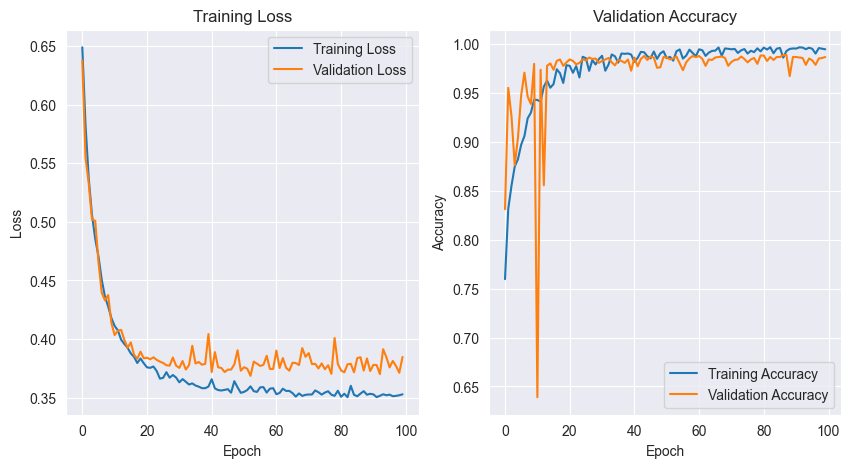

In [37]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [38]:
nn = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)
y_pred = nn.predict(X_test)

In [39]:
pred = np.argmax(y_pred.data, axis=1)

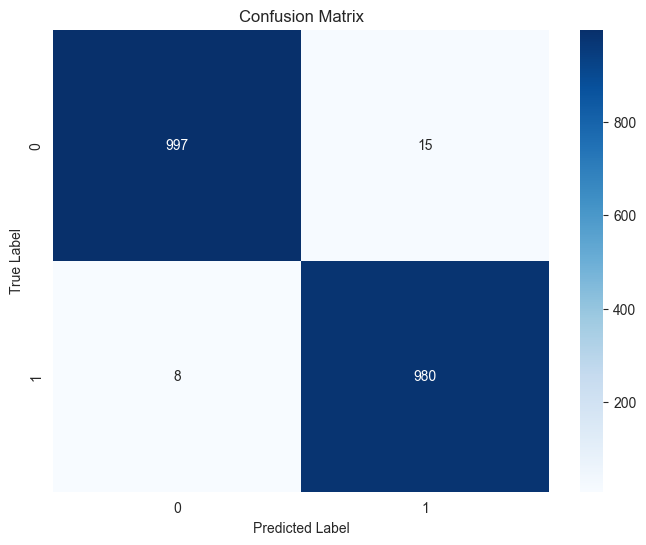

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test.astype(np.int8), np.argmax(y_pred, axis=1))